# Automated Machine Learning 
### Anomaly Detection | Angelika Lin

# Agenda 

1. [Data Preparation](#1)
     1. [Load packages](#1.1)
     2. [Initialize H2O](#1.2)
     3. [Load data & prep](#1.3)
     4. [Imbalance Data Check](#1.4)
2. [Model](#2)
    1. [Train/Test converting to H2O Frame, Target, and Predictors](#2.1)
    2. [Metrics:Gains Table, ROC/AUC, Variable Importance](#2.2)
    3. [Random Forest: on sample & entire dataset](#2.3)
3. [SHAP Values & Model Trials](#3)
    1. [Scikit-learn RF Model](#3.1)
    2. [Modeling 1](#3.2)
    3. [Kernal Explainer](#3.3) 
    4. [Summary Plot, Dependence Plot, Force Plot](#3.4)
4. [Final Model & SHAP Plots](#4)
    1. [Summary Plot](#4.1)
    2. [Dependence Plot](#4.2)
    3. [Force Plot](#4.3)

      
     

# 1. Data Preparation <a id="1"></a>

## 1.1 Load packages <a id="1.1"></a>

In [2]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import time
import itertools
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
%matplotlib inline
warnings.filterwarnings("ignore")
np.random.seed(0)

<a id="1.2"></a>
## 1.2 Initialize H2O | connect to the H2O server 

 <a id="1.3"></a>
## 1.3 Load data & prep

In [3]:
data = pd.read_csv("/Users/angelikalin/Library/Mobile Documents/com~apple~CloudDocs/CU_Summer22/5420_AnomalyDetection/HW_dataset/HW8_XYZloan_default_selected_vars.csv")

In [4]:
data.count

<bound method DataFrame.count of        Unnamed: 0.1  Unnamed: 0     id  loan_default  AP001  AP002  AP003  \
0                 0           1      1             1     31      2      1   
1                 1           2      2             0     27      1      1   
2                 2           3      3             0     33      1      4   
3                 3           4      4             0     34      2      4   
4                 4           5      5             0     47      2      1   
...             ...         ...    ...           ...    ...    ...    ...   
79995         79995       79996  79996             0     39      2      1   
79996         79996       79997  79997             0     31      1      4   
79997         79997       79998  79998             0     37      1      1   
79998         79998       79999  79999             0     38      2      1   
79999         79999       80000  80000             1     25      1      3   

       AP004            AP005    AP006  ..

In [5]:
data.shape

data.head()

,Unnamed: 0.1,Unnamed: 0,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,0,1,1,1,31,2,1,12,2017/7/6 10:21,ios,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,1,2,2,0,27,1,1,12,2017/4/6 12:51,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,2,3,3,0,33,1,4,12,2017/7/1 14:11,h5,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB
3,3,4,4,0,34,2,4,12,2017/7/7 10:10,android,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO
4,4,5,5,0,47,2,1,12,2017/7/6 14:37,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB


In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.20, random_state=42)

In [7]:
var = pd.DataFrame(train.dtypes)
var.head(10)

,0
Unnamed: 0.1,int64
Unnamed: 0,int64
id,int64
loan_default,int64
AP001,int64
AP002,int64
AP003,int64
AP004,int64
AP005,object
AP006,object


In [8]:
var = pd.DataFrame(train.dtypes).reset_index()
var.head()

,index,0
0,Unnamed: 0.1,int64
1,Unnamed: 0,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [9]:
var.columns = ['varname','dtype'] 
var.head(10)

,varname,dtype
0,Unnamed: 0.1,int64
1,Unnamed: 0,int64
2,id,int64
3,loan_default,int64
4,AP001,int64
5,AP002,int64
6,AP003,int64
7,AP004,int64
8,AP005,object
9,AP006,object


In [10]:
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0.1,int64,Un
1,Unnamed: 0,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [11]:
var['source'].value_counts()


CD    36
TD    24
AP     9
CR     8
PA     6
Un     2
MB     2
id     1
lo     1
Name: source, dtype: int64

In [12]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [13]:
train['loan_default'].value_counts(dropna=False)

0    51662
1    12338
Name: loan_default, dtype: int64

<a id="1.4"></a>
## 1.4 Imbalance Data Check

In [14]:
normal = train['loan_default'].value_counts(dropna=False)[0]
abnormal = train['loan_default'].value_counts(dropna=False)[1]
normal
abnormal

12338

In [15]:
abnormal/(normal+abnormal)

0.19278125

#### Comment: 
> Understanding that 19% of the data are abnormal, we can conclude that this is an imbalanced dataset. Hence, we will take that into further consideration when implementing it in H2O module.


--- 

<a id="2"></a>
# 2. Model 

<a id="2.1"></a>
## 2.1 H2O frame, train/test, target, predictors. 
As I have previously train/test split, I will still have to convert the dataframe to the ones that suits H2O. 

In [16]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,11 mins 07 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,1 month and 2 days
H2O_cluster_name:,H2O_from_python_angelikalin_s9mq9r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.702 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


In [17]:
train_hex = h2o.H2OFrame(train)
test_hex =h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [18]:
#sample data
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_smpl_hex= h2o.H2OFrame(train_smpl)
test_smpl_hex= h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [21]:
target = "loan_default"
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

<a id="2.2"></a>
## 2.2 Metrics 

### Gains Table 

In [22]:
# create a gain table for test sample data
def createGains(model,test_data):
    predictions = model.predict(test_data)
    test_scores = test_data['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)


### ROC & AUC 
Receiver Operating Characteristic Curve & Area Under Curvce 

In [23]:
# metric 2: receiver operating characteristic curve's area under curve
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)

    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false positive rate')
    print('')
    print('	  * The area under curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')

    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()


### Variable Importance

In [24]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()

<a id="2.3"></a>

## 2.3 Random Forest 
- Initialize the RF estimator 

### On sample data (0.1)

In [24]:
rf_v1 = H2ORandomForestEstimator(model_id="rf_v1",
                                seed=813,
                                ntrees=400, 
                                nfolds=5,
                                min_rows=100)

In [24]:
rf_v1.train(predictors, target, training_frame=train_smpl_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_v1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,400.0,400.0,185044.0,7.0,12.0,9.1575,27.0,33.0,29.965




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.1478646142179703
RMSE: 0.38453168168301854
MAE: 0.296570075872307
RMSLE: 0.2695853373578997
Mean Residual Deviance: 0.1478646142179703

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.14802578640308778
RMSE: 0.3847411940552867
MAE: 0.2972050100814601
RMSLE: 0.26975528831792994
Mean Residual Deviance: 0.14802578640308778

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.297136,0.004344,0.296112,0.298355,0.304029,0.294000,0.293186
1,mean_residual_deviance,0.147939,0.005102,0.146806,0.150174,0.155616,0.143955,0.143142
2,mse,0.147939,0.005102,0.146806,0.150174,0.155616,0.143955,0.143142
3,r2,0.034756,0.007145,0.035601,0.043848,0.024558,0.037788,0.031987
4,residual_deviance,0.147939,0.005102,0.146806,0.150174,0.155616,0.143955,0.143142
5,rmse,0.384583,0.006602,0.383153,0.387523,0.394482,0.379414,0.378341
6,rmsle,0.269681,0.003619,0.269004,0.270542,0.275456,0.266898,0.266503



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-08-10 17:18:02,5.847 sec,0.0,NaN,NaN,NaN
1,,2022-08-10 17:18:02,5.852 sec,1.0,0.392817,0.297150,0.154305
2,,2022-08-10 17:18:02,5.856 sec,2.0,0.390959,0.295321,0.152849
3,,2022-08-10 17:18:02,5.860 sec,3.0,0.386308,0.293344,0.149234
4,,2022-08-10 17:18:02,5.864 sec,4.0,0.387020,0.295129,0.149785
5,,2022-08-10 17:18:02,5.867 sec,5.0,0.385318,0.294636,0.148470
6,,2022-08-10 17:18:02,5.871 sec,6.0,0.387289,0.295482,0.149993
7,,2022-08-10 17:18:02,5.874 sec,7.0,0.386364,0.295056,0.149277
8,,2022-08-10 17:18:02,5.878 sec,8.0,0.386696,0.296018,0.149533
9,,2022-08-10 17:18:02,5.881 sec,9.0,0.386968,0.296909,0.149744



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD013,3053.997314,1.000000,0.191820
1,MB007,2712.955078,0.888329,0.170399
2,TD009,1937.426880,0.634390,0.121689
3,AP003,1457.438965,0.477223,0.091541
4,TD005,930.185913,0.304580,0.058424
5,TD014,502.293488,0.164471,0.031549
6,CR015,430.903137,0.141095,0.027065
7,PA029,391.744720,0.128273,0.024605
8,CR019,370.538391,0.121329,0.023273
9,TD023,320.402740,0.104913,0.020124



See the whole table with table.as_data_frame()


In [74]:
rf_predictions_smpl = rf_v1.predict(test_smpl_hex)
rf_predictions_smpl.head()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
0.291442
0.262491
0.207658
0.104289
0.190618
0.178438
0.1997
0.128781
0.255205
0.265626


In [75]:
rf_smpl_test_scores = test_smpl_hex['loan_default'].cbind(rf_predictions_smpl).as_data_frame()
rf_smpl_test_scores

,loan_default,predict
0,0,0.291442
1,0,0.262491
2,0,0.207658
3,0,0.104289
4,0,0.190618
...,...,...
1595,0,0.165888
1596,0,0.231920
1597,0,0.095780
1598,0,0.138126


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false positive rate

	  * The area under curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



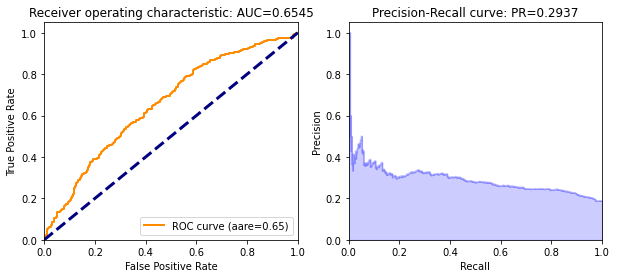

In [88]:
ROC_AUC(rf_v1,test_smpl_hex,'loan_default')

### On actual train/test data (entire dataset)

In [82]:
rf_v1.train(predictors, target, training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_v1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,400.0,400.0,1720971.0,13.0,20.0,15.93,290.0,314.0,302.6875




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14768070418932674
RMSE: 0.3842924721996604
MAE: 0.29671036953302765
RMSLE: 0.2694114591251764
Mean Residual Deviance: 0.14768070418932674

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.147695063274326
RMSE: 0.3843111542413595
MAE: 0.2968236024173376
RMSLE: 0.2693986012989622
Mean Residual Deviance: 0.147695063274326

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.296830,0.001382,0.296878,0.297175,0.295491,0.298927,0.295680
1,mean_residual_deviance,0.147702,0.001611,0.147029,0.148341,0.146680,0.150220,0.146241
2,mse,0.147702,0.001611,0.147029,0.148341,0.146680,0.150220,0.146241
3,r2,0.050876,0.003054,0.050667,0.046009,0.051279,0.052094,0.054330
4,residual_deviance,0.147702,0.001611,0.147029,0.148341,0.146680,0.150220,0.146241
5,rmse,0.384316,0.002092,0.383444,0.385150,0.382988,0.387583,0.382414
6,rmsle,0.269401,0.001079,0.269106,0.270143,0.268665,0.270856,0.268234



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-08-09 14:43:32,1 min 13.018 sec,0.0,NaN,NaN,NaN
1,,2022-08-09 14:43:32,1 min 13.058 sec,1.0,0.386983,0.295446,0.149756
2,,2022-08-09 14:43:32,1 min 13.099 sec,2.0,0.389091,0.296519,0.151392
3,,2022-08-09 14:43:32,1 min 13.135 sec,3.0,0.389411,0.296704,0.151641
4,,2022-08-09 14:43:32,1 min 13.169 sec,4.0,0.389802,0.297430,0.151945
5,,2022-08-09 14:43:32,1 min 13.202 sec,5.0,0.388825,0.297336,0.151185
6,,2022-08-09 14:43:32,1 min 13.234 sec,6.0,0.388250,0.297099,0.150738
7,,2022-08-09 14:43:32,1 min 13.269 sec,7.0,0.387803,0.297127,0.150391
8,,2022-08-09 14:43:32,1 min 13.303 sec,8.0,0.387400,0.297122,0.150079
9,,2022-08-09 14:43:32,1 min 13.338 sec,9.0,0.387203,0.297235,0.149926



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD013,27923.380859,1.000000,0.133119
1,AP003,26719.214844,0.956876,0.127379
2,TD009,23075.843750,0.826399,0.110010
3,MB007,21936.621094,0.785600,0.104579
4,TD005,15676.115234,0.561397,0.074733
5,AP005,10608.178711,0.379903,0.050572
6,CR015,9514.765625,0.340745,0.045360
7,TD014,8600.108398,0.307990,0.040999
8,MB005,5512.185059,0.197404,0.026278
9,TD010,4373.388672,0.156621,0.020849



See the whole table with table.as_data_frame()


In [83]:
rf_predictions = rf_v1.predict(test_hex)
rf_predictions.head()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
0.108817
0.184496
0.0945254
0.22486
0.436934
0.109258
0.383094
0.208029
0.156113
0.158097


In [84]:
rf_test_scores = test_hex['loan_default'].cbind(rf_predictions).as_data_frame()
rf_test_scores

,loan_default,predict
0,0,0.108817
1,0,0.184496
2,0,0.094525
3,1,0.224860
4,0,0.436934
...,...,...
15995,0,0.210986
15996,0,0.406686
15997,1,0.204024
15998,0,0.138990


In [85]:
createGains(rf_v1,test_hex)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,620,980,1600,620,980,0.20,0.08,315.0,1.97,12.0,38.75
1,1600,483,1117,3200,1103,2097,0.35,0.16,630.0,1.75,19.0,34.47
2,1600,392,1208,4800,1495,3305,0.47,0.26,945.0,1.58,21.0,31.15
3,1600,355,1245,6400,1850,4550,0.59,0.35,1260.0,1.47,24.0,28.91
4,1600,316,1284,8000,2166,5834,0.69,0.45,1575.0,1.38,24.0,27.08
5,1600,283,1317,9600,2449,7151,0.78,0.56,1890.0,1.30,22.0,25.51
6,1600,234,1366,11200,2683,8517,0.85,0.66,2205.0,1.22,19.0,23.96
7,1600,199,1401,12800,2882,9918,0.91,0.77,2520.0,1.14,14.0,22.52
8,1600,155,1445,14400,3037,11363,0.96,0.88,2835.0,1.07,8.0,21.09


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false positive rate

	  * The area under curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



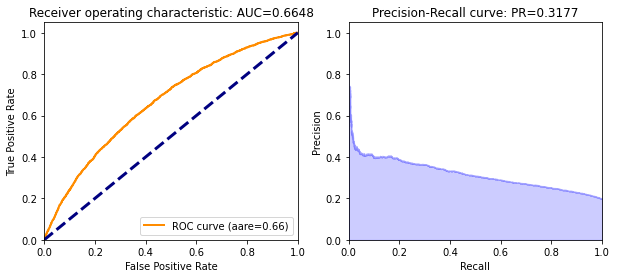

In [86]:
ROC_AUC(rf_v1,test_hex,'loan_default')

#### Comment 
> After generating both the sample v.s the entire dataset with the same model, there is a slight improvement on the accuracy, increasing the AUC score from 0.6545 to 0.6648. 

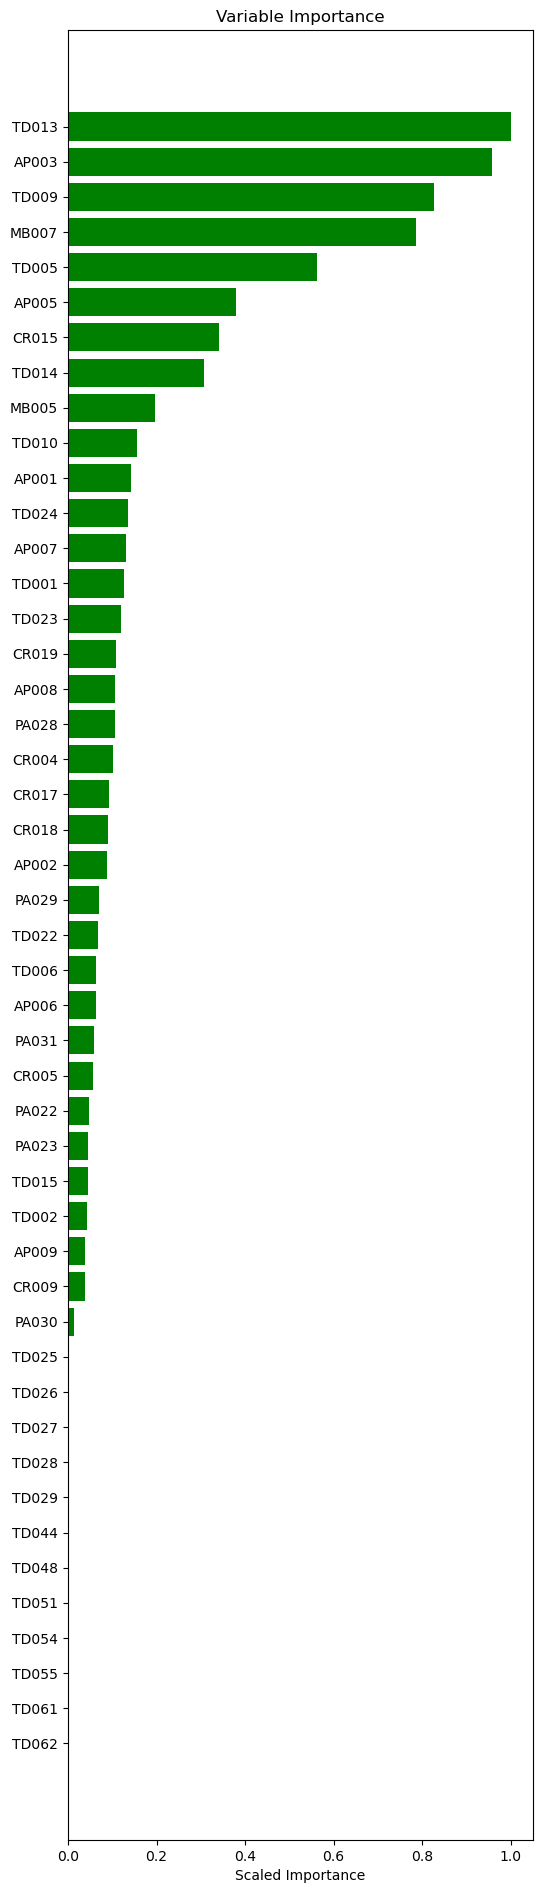

In [90]:
VarImp(rf_v1)

<a id="3"></a>
# 3. SHAP Values & Model Trial 

In [74]:
import shap
shap.initjs()

<a id="3.1"></a>
## 3.1 Running Sckitlearn RF Model with the top 10 variables 

#### Instruction
- Scikit-learn decision tree methods need appropriate variable transformation including missing imputation or categorical binning, etc. Please see "Avoid These Deadly Modeling Mistakes that May Cost You a CareerLinks to an external site.". If you are more familiar with R dplyr, you can prepare your modeling data in R, save as a .csv file, then just use scikit-learn for the SHAP Values.
- Please use the top variables learned from your previous models (RF) to run your scikit-learn random forest model.
- Please keep the top 10 variables.

### Encoding 
Since one of the top 10 variables is categorical variable "MB007", I will encode it with frequency encoding. 
>In the cases where the frequency is related somewhat with the target variable, it helps the model to understand and assign the weight in direct and inverse proportion, depending on the nature of the data.

In [26]:
data.dtypes[data.dtypes==object]

AP005    object
AP006    object
MB007    object
dtype: object

In [27]:
def encode_FE(df, cols):
    for col in cols:
        vc = df[col].value_counts(normalize=True).to_dict()
        vc[-1] = -1
        #nm = col+'_FE'
        df[col] = df[col].map(vc)
        df[col] = df[col].astype('float32')
        print(col,', ',end='')
        #return df1, df2

encode_FE(data,['MB007'])

MB007 , 

In [28]:
data['MB007'].head()

# succesfully converted! 

0    0.079187
1    0.548125
2    0.548125
3    0.053913
4    0.548125
Name: MB007, dtype: float32

In [29]:
data['MB005'] = data.groupby('MB007')['MB005'].ffill(limit=1)

In [30]:
data['MB005'].mean()
data['MB005']=data['MB005'].fillna(value=6)

## 3.2 Modeling 1 

In [31]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

Y = data['loan_default']
X = data[['TD013','AP003','TD009','MB007','TD005',
          'CR015','TD014','MB005','TD010','AP001']]

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.005)

In [297]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, Y_train)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  41.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  46.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  49.9s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  46.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  50.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  47.1s


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  50.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 1.1min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  41.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  39.3s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  39.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  18.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  40.0s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 1.1min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  41.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  39.0s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 1.1min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  39.9s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  39.7s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  40.3s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  53.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 2.9min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  52.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  18.1s
[CV] END bootstrap=False, max_depth=30, m

/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=  55.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  43.7s


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  48.5s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  43.7s


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  48.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  43.4s


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time= 5.2min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=  55.3s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time= 1.7min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 1.1min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 1.9min
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  39.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time= 2.8min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 1.1min
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time= 1.7min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 1.1min
[CV] END bootstrap=False, max_depth=70

/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  39.9s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time= 2.8min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=  55.2s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time= 4.9min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  48.7s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time= 4.8min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 3.1min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 1.1min
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time= 1.7min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 1.9min
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time= 1.8min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=  55.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  28.3s


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=  55.7s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time= 1.6min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time= 1.6min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  40.8s


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time= 5.0min
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 4.2min
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time= 4.8min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  27.8s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 4.3min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  32.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  50.0s


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time= 5.2min
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  44.6s


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  12.9s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=  35.6s


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  24.2s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 1.2min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 1.6min
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  18.2s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 4.0min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=  53.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  46.0s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 1.6min
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=  35.4s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 4.0min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time= 1.8min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  28.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  41.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  41.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=  49.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; total time= 1.1min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=  51.5s
[CV] END bootstrap=True, max_depth=5

/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time= 2.8min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 1.7min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time= 4.6min
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=  56.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time= 3.3min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; total time= 1.1min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=  52.4s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time= 1.2min
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 1.5min
[CV] END bootstrap=True, max_depth=6

/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time= 5.4min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  13.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  12.9s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=  36.2s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 4.0min
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time= 2.8min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 1.7min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=  40.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time= 1.9min
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=  57.0s


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time= 1.9min
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=  58.3s


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 2.7min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time= 1.1min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 2.7min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time= 1.1min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 2.7min
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time= 3.3min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time= 2.7min
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time= 2.6min
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time= 3.2min
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time= 2.6min
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.0min
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time= 1.4min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 4.2min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  31.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=  46.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  50.3s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  44.4s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  24.9s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  37.1s
[CV] END bootstrap=False, max_depth=80,

/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time= 6.1min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time= 3.4min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time= 2.8min
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.1min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=  46.6s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time= 1.3min
[CV] END bootstrap=False, max_dep

/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time= 2.8min
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time= 5.5min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time= 2.8min
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time= 5.5min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  25.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time= 5.5min


/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time= 1.2min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  25.4s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  20.6s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  21.4s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time= 1.1min
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  48.5s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=  38.7s
[CV] END bootstrap=True, max_depth=100

/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time= 1.6min
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time= 5.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time= 1.5min
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  37.3s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 1.3min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time= 6.0min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time= 3.4min
[CV] END bootstrap=False, max_dep

/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/angelikalin/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

### Comment 
> It ran for roughly an hour. 


{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}


In [24]:
rf = RandomForestRegressor(n_estimators=1600,
                           min_samples_split=2,
                           min_samples_leaf=4,
                           max_features='sqrt', 
                           max_depth=10, 
                           bootstrap=True
                          )

[0.16568019 0.13233316 0.12023764 0.07340802 0.09577227 0.06753594
 0.08348961 0.1018078  0.06123098 0.0985044 ]


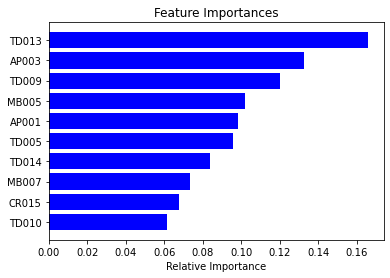

In [25]:
rf.fit(X_train, Y_train)  
print(rf.feature_importances_)

importances = rf.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

<a id="3.3"></a>
## 3.3 Kernel Explainer 
> I'd like to try on a tiny example 

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.0001)

In [30]:
#Running with a very small sample (X_test!)
shap.initjs()

In [39]:
rf_explainer = shap.KernelExplainer(rf.predict, X_test)
rf_shap_values = rf_explainer.shap_values(X_test)

  0%|          | 0/8 [00:00<?, ?it/s]

In [40]:
rf_shap_values

array([[-0.02216721,  0.01583669, -0.02214476, -0.00590732, -0.01407629,
         0.03179823, -0.00963888,  0.0288202 , -0.00232688,  0.0021374 ],
       [ 0.00651816,  0.01899416,  0.00506649, -0.00169957,  0.00980486,
         0.01956372, -0.00772379, -0.00716697, -0.00344081, -0.00129469],
       [ 0.01754695,  0.01853175,  0.02870917,  0.00717142,  0.00799939,
        -0.02606643,  0.00763655,  0.00898216,  0.00308475,  0.00481417],
       [-0.0278135 , -0.040926  , -0.0170772 , -0.00104494, -0.00581347,
        -0.01276456, -0.00539396, -0.00271005, -0.00469864,  0.00262602],
       [ 0.02052866, -0.05877975,  0.00680504, -0.00162132,  0.00857353,
         0.01419964,  0.00256659, -0.00205912,  0.00279396, -0.00334764],
       [-0.01750144,  0.01171507, -0.0105849 ,  0.00797995, -0.01175776,
        -0.01506378,  0.01222037, -0.02483421,  0.01146257, -0.00126798],
       [ 0.01038073,  0.02206203, -0.00290359, -0.00151093,  0.01278458,
         0.01675662,  0.00825235,  0.02691539

In [41]:
rf_explainer.expected_value

0.17305821248623698

<a id="3.4"></a>
## 3.4 Force Plot, Summary Plot, and Dependence Plot | Test Data 

In [42]:
shap.force_plot(rf_explainer.expected_value, rf_shap_values, X_test)

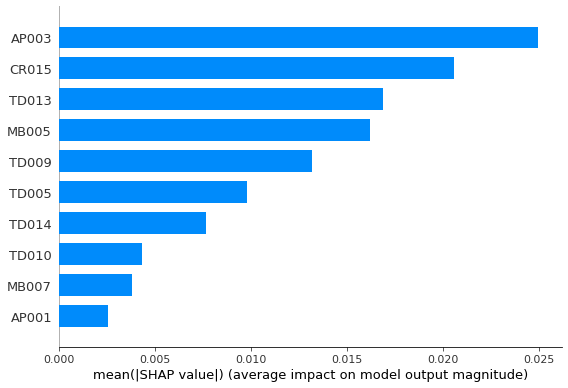

In [43]:
shap.summary_plot(rf_shap_values, X_test, plot_type="bar")

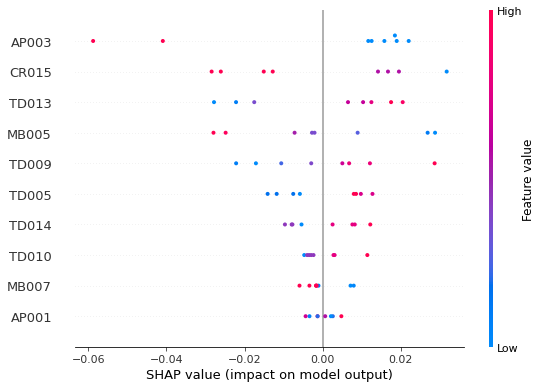

In [44]:
shap.summary_plot(rf_shap_values, X_test)

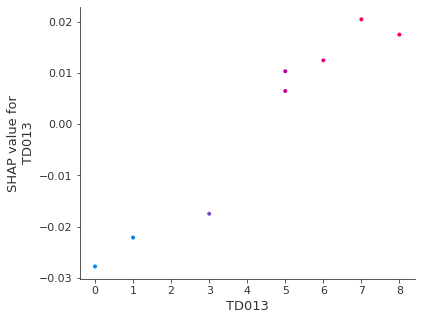

In [45]:
shap.dependence_plot("TD013", rf_shap_values, X_test)

<a id="4"></a>
# 4. Final Model & SHAP Plots 
- Using the Random Forest Model built earlier, but on the full dataset. 
- Using Tree Explainer 

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [33]:
rf2 = RandomForestRegressor(n_estimators=500,
                           min_samples_split=2,
                           min_samples_leaf=4,
                           max_features='sqrt', 
                           max_depth=5, 
                           bootstrap=True
                          )

rf2.fit(X_train, Y_train)  

RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=4,
                      n_estimators=500)

In [34]:
shap_values = shap.TreeExplainer(rf2).shap_values(X_train)

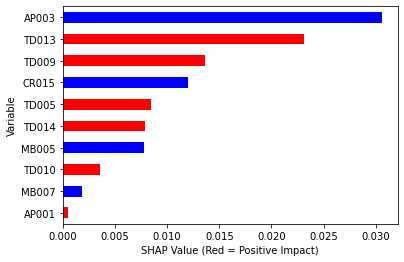

In [35]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(6,4),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train)  

<a id="4.1"></a>
## 4.1 Summary Plot  | Train Data 

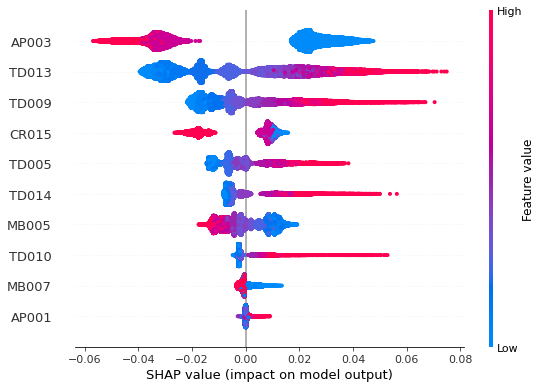

In [36]:
shap.summary_plot(shap_values, X_train)

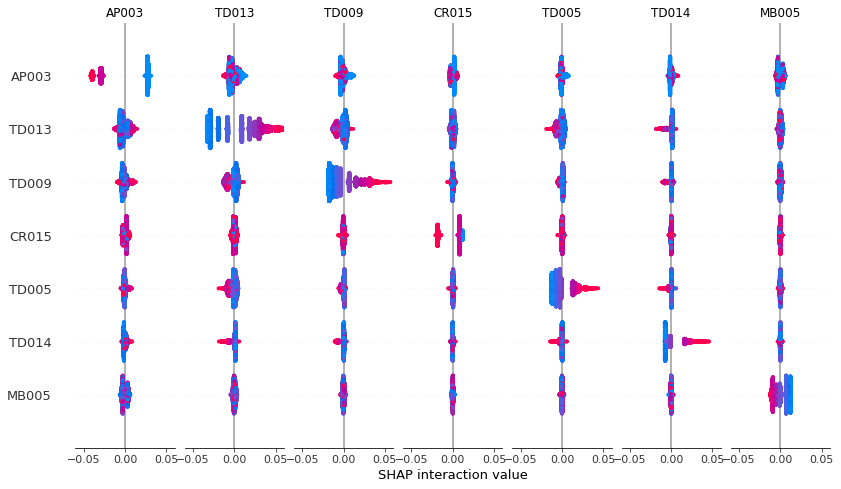

In [62]:
shap_interaction_values = shap.TreeExplainer(rf2).shap_interaction_values(X_train.iloc[:8000,:])

shap.summary_plot(shap_interaction_values, X_train.iloc[:8000,:])

<a id="4.2"></a>
## 4.2 Dependence Plot on Top 5 Variables | Train Data 

> Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted loan default rate. The colors help reveal interactions of a selected feature with another feature

### Top 1 | AP003 : code_education 
> Lower educatioin code mostly has a positive SHAP values, and vice versa: this indicates that higher education codes have lower loan_default rate.
   

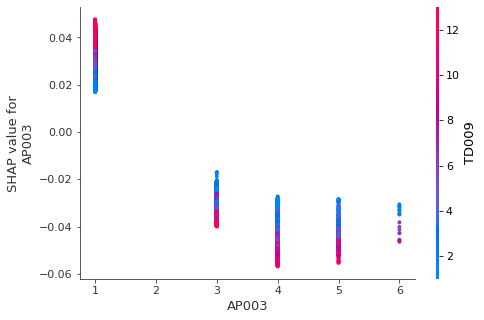

In [49]:
shap.dependence_plot("AP003", shap_values, X_train)

### Top 2 | TD013 : TD_CNT_QUERY_LAST_6MON_P2P 
> SHAP values above y=0 line lead to predictions of higher loan default. Hence, in this case, higher Peer to Peer lending in the past 6 months would lead to higher change of loan defaults

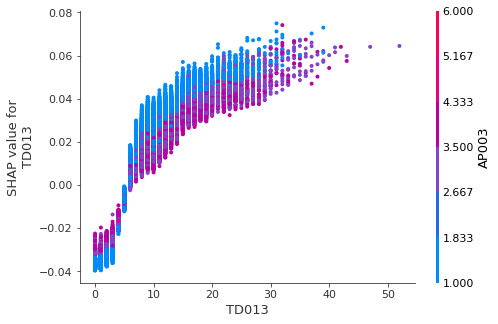

In [48]:
shap.dependence_plot("TD013", shap_values, X_train)

### Top 3 | TD009 : TD_CNT_QUERY_LAST_3MON_P2P 
> Similarly, in this case, higher Peer to Peer lending in the past 3 months would lead to higher change of loan defaults

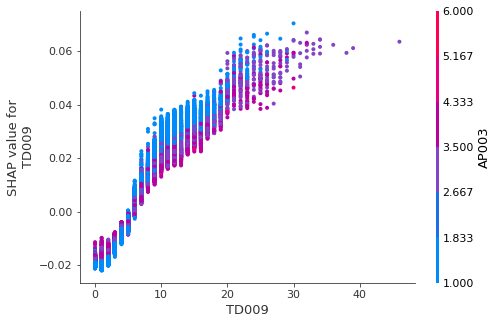

In [56]:
shap.dependence_plot("TD009", shap_values, X_train)

### Top 4 | CR015 : MONTH_CREDIT_CARD_MOB_MAX 
> Another credit issue, similar to the last 2 (Top 2 and 3). In general, when there is Monthly Outstanding Balance, the more loan defaults will occur. Higher MOB suggests a stronger negative impact on the loan default. 

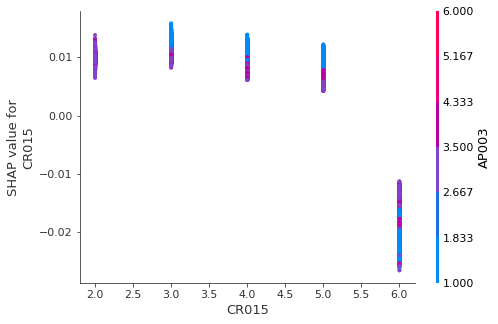

In [57]:
shap.dependence_plot("CR015", shap_values, X_train)

### TD005 : TD_CNT_QUERY_LAST_1MON_P2P 
> In this case, higher Peer to Peer lending in the past 1 month would lead to higher chance of loan defaults. 

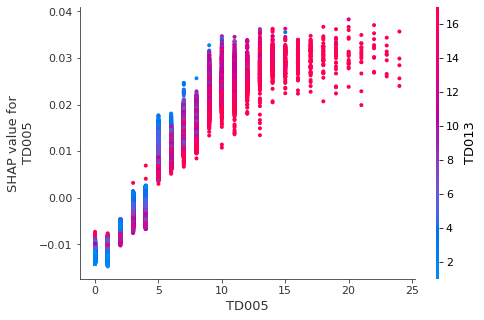

In [58]:
shap.dependence_plot("TD005", shap_values, X_train)

<a id="4.3"></a>
## 4.3 Force Plot  | Train Data 

In [66]:
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(rf2.predict(X_output),2)

random_picks = np.arange(1,330,50)
S = X_output.iloc[random_picks]
S

,TD013,AP003,TD009,MB007,TD005,CR015,TD014,MB005,TD010,AP001,predict
3509,9,3,7,0.052963,5,4,1,3.0,1,25,0.21
5668,5,1,5,0.548125,3,5,1,11.0,1,30,0.20
55849,5,1,5,0.025688,5,6,1,11.0,1,47,0.18
29484,12,3,5,0.548125,5,6,5,5.0,2,27,0.19
17237,1,1,0,0.053913,0,5,0,8.0,0,38,0.14
31155,12,3,12,0.548125,8,6,3,4.0,3,27,0.22
53868,11,4,11,0.548125,6,6,5,9.0,4,29,0.18


In [67]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(rf2)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [68]:
X_train.mean()

TD013     6.805503
AP003     2.014724
TD009     5.406432
MB007     0.321667
TD005     3.592739
CR015     4.924862
TD014     2.604183
MB005     5.976055
TD010     2.021043
AP001    31.708555
dtype: float64

In [69]:
Y_test.mean()

0.1825

In [75]:
shap.initjs()

In [76]:
shap_plot(0)

In [77]:
shap_plot(1)

In [78]:
shap_plot(2)

In [79]:
shap_plot(3)

In [80]:
shap_plot(4)

### Comment 
> Force plots displayed the key information in a condensed format. Where the stacked plots are indicative of the predicted loan default rate would be impacted by variables. 

# Summary 

#### Conclusion
> Building model and implementing SHAP values in order to gain insights to how variables impact predictions. The conventional feature importances are measured by how much it can improve the model's predictive performance. 
</br> 
</br>
The SHAP values generated in this exercise have elaborated on how the input variables impacted the individual predictions. 
</br> 
</br>
The top 5 variables that have the most impact on the model predictions are education, credibility -- specifically in regards to their peer-to-peer loaning history, as well as records of outstanding balances. It is indeed intuitive to draw to this conclusion. However, SHAP values gave us a debrief on how specific values in the variables impacted our model predictions. 
</br> 


#### Comments for Future Implementation: 
> I have succesfully ran 300 models and selected the best performing parameters for tuning for model 1 (rf). Unfortunately, the model took forever to run with my full dataset, hence I reduced the tuning to the current model (rf2). 
</br> 
</br>
I wonder if it will be much faster if it's locally ran?
</br> 
</br>
At last, it's been a great series of coding exercises in this course for me. Many many thanks to Professor Kuo, David, and John.